# DEMAND FORECASTING

In [1]:
# Importing useful libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import datetime
#import tensorflow as tf
import sklearn
#from tensorflow import keras
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, KFold

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, PolynomialFeatures, LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

import lightgbm
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Reading files
train=pd.read_excel('train.xlsx')

In [3]:
test=pd.read_excel('test.xlsx')

In [4]:
print(train.dtypes)

date      datetime64[ns]
hour               int64
demand             int64
dtype: object


In [5]:
train.head()

,date,hour,demand
0,2018-08-18,9,91
1,2018-08-18,10,21
2,2018-08-18,13,23
3,2018-08-18,14,104
4,2018-08-18,15,81


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18247 entries, 0 to 18246
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    18247 non-null  datetime64[ns]
 1   hour    18247 non-null  int64         
 2   demand  18247 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 427.8 KB


### CREATING ADDITIONAL FEATURES FROM DATE COLUMN

In [7]:
train['month'] = train['date'].dt.month

In [8]:
train['week'] = train['date'].dt.week

In [9]:
train['day'] =train['date'].dt.day

In [10]:
train['weekday'] = train['date'].dt.weekday

In [11]:
train['year'] = train['date'].dt.year

In [12]:
train['year'].unique()

array([2018, 2019, 2020, 2021])

In [13]:
train['day_of_year'] = train['date'].dt.day_of_year

In [14]:
train['is_month_start'] = train['date'].dt.is_month_start

In [15]:
train['is_month_end'] = train['date'].dt.is_month_end

In [16]:
train['is_quarter_start'] = train['date'].dt.is_quarter_start

In [17]:
train['is_quarter_end'] = train['date'].dt.is_quarter_end

In [18]:
train['is_year_end'] = train['date'].dt.is_year_end

In [19]:
train['is_year_start'] = train['date'].dt.is_year_start

In [20]:
years=list(train['year'].unique())+ list(test['date'].dt.year.unique())

In [21]:
import holidays

#Select country and create a holiday list
holidays = holidays.India(years = years)
holiday_list=[d for d in holidays.keys()]

train['is_holiday']=train['date'].apply(lambda x: 1 if x in holiday_list else 0)

In [22]:
#day_part function
def day_part(hour):
    if hour in [4,5,6]:
        return "early morning"
    elif hour in [7,8]:
        return "morning"
    elif hour in [9,10, 11]:
        return "late morning"
    elif hour in [12,13,14]:
        return "noon"
    elif hour in [15,16,17]:
        return "afternoon"
    elif hour in [18,19]:
        return "evening"
    elif hour in [20, 21, 22]:
        return "night"
    elif hour in [23,0,1,2,3]:
        return "midnight"
    
    
#Run function with apply method
train['day_part'] = train['hour'].apply(day_part)

### EDA

#### Demand (target variable)

<function matplotlib.pyplot.show>

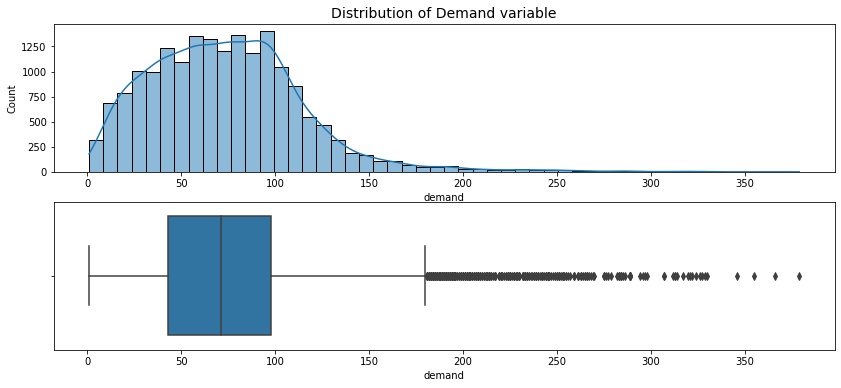

In [23]:
plt.figure(figsize=(14,6))
plt.subplot(2,1,1)
sns.histplot(data=train['demand'], kde = True, bins=50)
plt.title('Distribution of Demand variable',fontsize=14)
plt.subplot(2,1,2)
sns.boxplot(x='demand', data=train)
plt.show


#### Year (Independant variable)

Text(0.5, 1.0, 'Yearly demand')

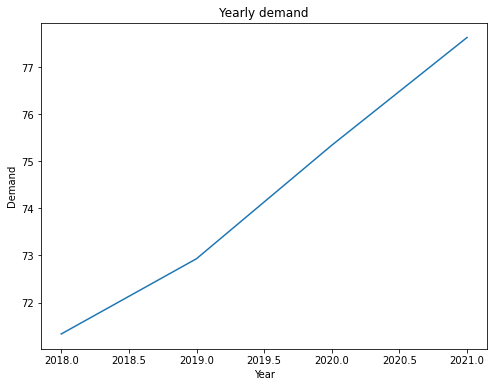

In [24]:
train.groupby('year')['demand'].mean().plot( kind = 'line', figsize = (8,6))
plt.ylabel('Demand')
plt.xlabel('Year')
plt.title('Yearly demand')

The average demand is steeply increasing on yearly basis.

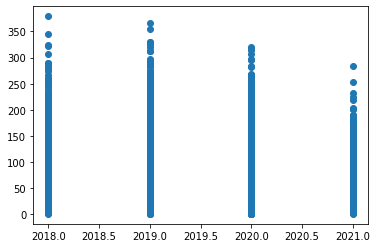

In [25]:
plt.scatter(train['year'], train['demand'])

The demand is fairly same year-wise except cases where there were some unusual peaks  in the past years, that are against the average trend. 

#### Hour(Independant variable)

Text(0.5, 1.0, 'Hourly demand')

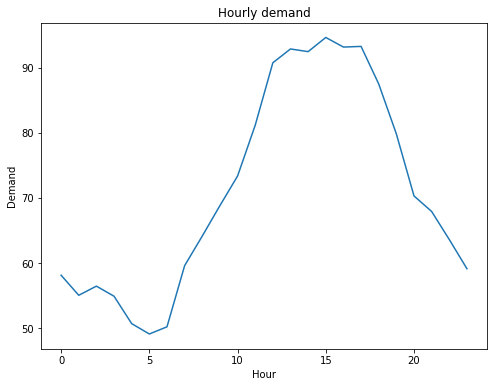

In [26]:
train.groupby('hour')['demand'].mean().plot( kind = 'line', figsize = (8,6))
plt.ylabel('Demand')
plt.xlabel('Hour')
plt.title('Hourly demand')

The demand is at peak betweek 12pm to 5pm. and is the lowest from 4am  to 6am.

#### Month(Independant variable)

Text(0.5, 1.0, 'Monthly demand')

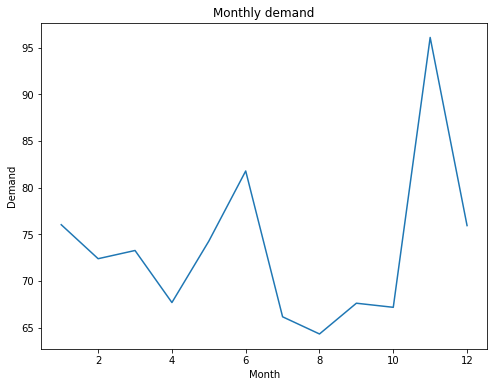

In [27]:
train.groupby('month')['demand'].mean().plot( kind = 'line', figsize = (8,6))
plt.ylabel('Demand')
plt.xlabel('Month')
plt.title('Monthly demand')

The demand is at peak in the months of June and November and the lowest from July to October.

#### Weekday(Independant variable)

Text(0.5, 1.0, 'Demand vs Day of week')

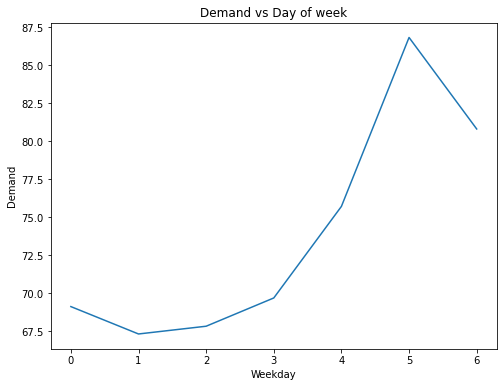

In [28]:
train.groupby('weekday')['demand'].mean().plot(kind = 'line', figsize = (8,6))
plt.ylabel('Demand')
plt.xlabel('Weekday')
plt.title('Demand vs Day of week')

Demand is highest on Saturday and Sunday and lowest on Monday and Tuesday

Text(0.5, 1.0, 'Yearly demand')

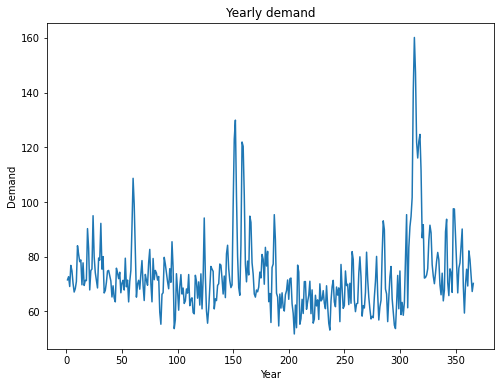

In [29]:
train.groupby('day_of_year')['demand'].mean().plot( kind = 'line', figsize = (8,6))
plt.ylabel('Demand')
plt.xlabel('Year')
plt.title('Yearly demand')

### TRAIN TEST SPLIT

In [30]:
train=train.reset_index(drop=True)

In [31]:
train.columns

Index(['date', 'hour', 'demand', 'month', 'week', 'day', 'weekday', 'year',
       'day_of_year', 'is_month_start', 'is_month_end', 'is_quarter_start',
       'is_quarter_end', 'is_year_end', 'is_year_start', 'is_holiday',
       'day_part'],
      dtype='object')

In [32]:
# Identifying indices of potential outliers
indices=train[train['demand']>= 250].index.to_list()

In [33]:
#deleting outliers
train=train.drop(indices, axis=0)

In [34]:
X=train.drop(['date', 'demand'], axis=1)

In [35]:
y=train['demand']

In [36]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.10, random_state=1)

### FEATURE LISTS

In [37]:
cat_cols=[col for col in X.columns if 'is' in col]

In [38]:
cat_cols= cat_cols + ['day_part']

In [39]:
num_cols= [col for col in X.columns if col not in  cat_cols]

In [40]:
num_cols

['hour', 'month', 'week', 'day', 'weekday', 'year', 'day_of_year']

### TRAINING DATA

In [41]:
def fit_pipeline(numcollist, catcollist,  X_train, y_train, final_estimator):
    """This function creates a pre-processing pipeline and fits the data using the final estimator."""
  
    # Define preprocessing for numeric columns (scale them)
    num_pipeline=Pipeline([('poly_features', PolynomialFeatures(degree=2)),('scaler', StandardScaler())])
    
    # Define preprocessing for categorical features (encode them)
    cat_pipeline=Pipeline([('ohc', OneHotEncoder(drop='if_binary'))])

    
    # Combine preprocessing steps
    preprocessor=ColumnTransformer(transformers=[('num', num_pipeline,numcollist), ('cat', cat_pipeline, catcollist)])
        
    # Create preprocessing and training pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', final_estimator)])
    
    model= pipeline.fit(X_train, y_train)
    
    return model

In [42]:
# FUNCTION TO EVALUATE MODEL PERFORMANCE
def evaluate_model(model):
  """This function evaluates the model on train and test with different metrics"""
  train_pred=model.predict(X_train)
  test_pred=model.predict(X_test)
  print('Root mean sqaured error on train set is {}'.format(round(np.sqrt(mean_squared_error(y_train, train_pred)),2)))
  print('Root mean sqaured error on test set is {}'.format(round(np.sqrt(mean_squared_error(y_test, test_pred)),2)))
  

In [43]:
X_train=X_train
y_train=y_train
numcollist=num_cols
catcollist=cat_cols




In [44]:
# Calling the functions and training
final_estimator=LGBMRegressor(n_estomators=400, num_leaves=40,reg_lambda=.02,random_state=1)
lgbm_model=fit_pipeline(numcollist, catcollist,  X_train, y_train, final_estimator)
evaluate_model(lgbm_model)

Root mean sqaured error on train set is 28.24
Root mean sqaured error on test set is 30.87


### PREPARING TEST SET

In [47]:
# Function to add new features to test data
def create_data(df):
    df['month'] = df['date'].dt.month
    df['week'] = df['date'].dt.week
    df['day'] =df['date'].dt.day
    df['weekday'] = df['date'].dt.weekday
    df['year'] = df['date'].dt.year
    df['day_of_year'] = df['date'].dt.day_of_year
    df['is_month_start'] = df['date'].dt.is_month_start
    df['is_month_end'] = df['date'].dt.is_month_end
    df['is_quarter_start'] = df['date'].dt.is_quarter_start
    df['is_quarter_end'] = df['date'].dt.is_quarter_end
    df['is_year_end'] = df['date'].dt.is_year_end
    df['is_year_start'] = df['date'].dt.is_year_start
    df['is_holiday']=df['date'].apply(lambda x: 0 if x in holiday_list else 0)
    df['day_part'] = df['hour'].apply(day_part)
    cols=num_cols+cat_cols
    df=df[cols]
    
    return df

In [48]:
test=create_data(test)

### PREDICTIONS ON TEST DATA & SUBMISSION

In [49]:
sample_submission=pd.read_excel('sample_submission.xlsx')

In [50]:
predictions=lgbm_model.predict(test)
sample_submission['demand']=predictions.astype('int')
sample_submission.to_csv('lgbm_final3.csv', index=False)